# Environment setup and dataset loading

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/customer-behavior-analytcis/customer_behavior_analytcis.csv


In [2]:
df = pd.read_csv("/kaggle/input/customer-behavior-analytcis/customer_behavior_analytcis.csv")

## Understanding Dataset

In [3]:
df.shape

(999, 6)

In [4]:
df.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
0,7.0,129.34,52.17,18.0,0.0,CM00000
1,22.0,24.18,9.19,15.0,7.0,CM00001
2,2.0,32.18,90.69,50.0,2.0,CM00002
3,25.0,26.85,11.22,16.0,10.0,CM00003
4,7.0,125.45,34.19,30.0,3.0,CM00004


In [5]:
for col in df.columns:
    print(df[col].value_counts())
    

total_purchases
5.0     89
7.0     68
6.0     65
4.0     62
8.0     58
3.0     52
13.0    50
9.0     50
12.0    41
10.0    39
11.0    35
14.0    32
18.0    32
21.0    28
19.0    28
22.0    28
15.0    27
20.0    27
17.0    27
16.0    26
2.0     22
23.0    19
24.0    16
25.0    12
27.0    12
26.0     8
1.0      7
29.0     6
28.0     5
30.0     4
32.0     2
0.0      2
Name: count, dtype: int64
avg_cart_value
33.29    3
27.63    3
49.51    3
37.90    2
20.39    2
        ..
46.93    1
44.89    1
11.08    1
20.62    1
39.29    1
Name: count, Length: 943, dtype: int64
total_time_spent
26.71    3
26.77    3
29.25    2
26.72    2
47.02    2
        ..
35.72    1
22.90    1
22.67    1
23.66    1
9.99     1
Name: count, Length: 953, dtype: int64
product_click
17.0    58
18.0    56
19.0    54
16.0    51
15.0    45
        ..
4.0      1
34.0     1
66.0     1
5.0      1
62.0     1
Name: count, Length: 64, dtype: int64
discount_counts
1.0     224
0.0     165
2.0     142
3.0      84
4.0      48
9.0  

# Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 non-null    float64
 3   product_click     979 non-null    float64
 4   discount_counts   999 non-null    float64
 5   customer_id       999 non-null    object 
dtypes: float64(5), object(1)
memory usage: 47.0+ KB


**From the above output, we can conclude and note that:**

- There are missing values in total_purchases, avg_cart_value, and product_click.
- customer_id (dtype: object) is not parsed as int/ float.
- So we will need to format customer_id into numeric form.

In [7]:
for column in df.columns:
    if df[column].isnull().any():
        df[column].fillna(df[column].median(), inplace=True)

# Data preprocessing

In [8]:
df['customer_id'] = df['customer_id'].str.extract('(\d+)').astype(int)

In [9]:
df.describe()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,11.539540,74.935896,49.348759,28.093093,4.313313,499.000000
std,6.949156,54.635622,32.730973,16.164124,4.532772,288.530761
min,0.000000,10.260000,5.120000,4.000000,0.000000,0.000000
25%,6.000000,33.350000,22.375000,16.000000,1.000000,249.500000
50%,10.000000,49.380000,40.360000,21.000000,2.000000,499.000000
75%,17.000000,118.490000,77.170000,45.000000,8.000000,748.500000
max,32.000000,199.770000,119.820000,73.000000,21.000000,998.000000


In [10]:
ds = df.copy()
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [11]:
scaled_ds.describe()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
count,9.990000e+02,9.990000e+02,9.990000e+02,9.990000e+02,9.990000e+02,999.000000
mean,-1.778135e-17,2.524952e-16,-1.209132e-16,6.756913e-17,5.690032e-17,0.000000
std,1.000501e+00,1.000501e+00,1.000501e+00,1.000501e+00,1.000501e+00,1.000501
min,-1.661399e+00,-1.184361e+00,-1.351958e+00,-1.491275e+00,-9.520606e-01,-1.730318
25%,-7.975521e-01,-7.615311e-01,-8.245178e-01,-7.485188e-01,-7.313345e-01,-0.865159
50%,-2.216543e-01,-4.679858e-01,-2.747630e-01,-4.390368e-01,-5.106085e-01,0.000000
75%,7.861668e-01,7.975734e-01,8.504231e-01,1.046476e+00,8.137477e-01,0.865159
max,2.945783e+00,2.285993e+00,2.154123e+00,2.779575e+00,3.683186e+00,1.730318


Note\
discunt counts seems to be spread away from means in contrast to other features. max > 3 and min<-3.

## Dimension Reduction

### PCA

In [12]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,999.0,-5.690032e-17,1.782441,-3.022556,-1.781907,-0.127880,1.797192,3.652439
col2,999.0,7.112540e-18,1.140669,-1.821071,-0.860465,-0.503547,1.152172,2.476460
col3,999.0,0.000000e+00,0.995396,-1.896521,-0.861309,0.012746,0.853450,1.941281


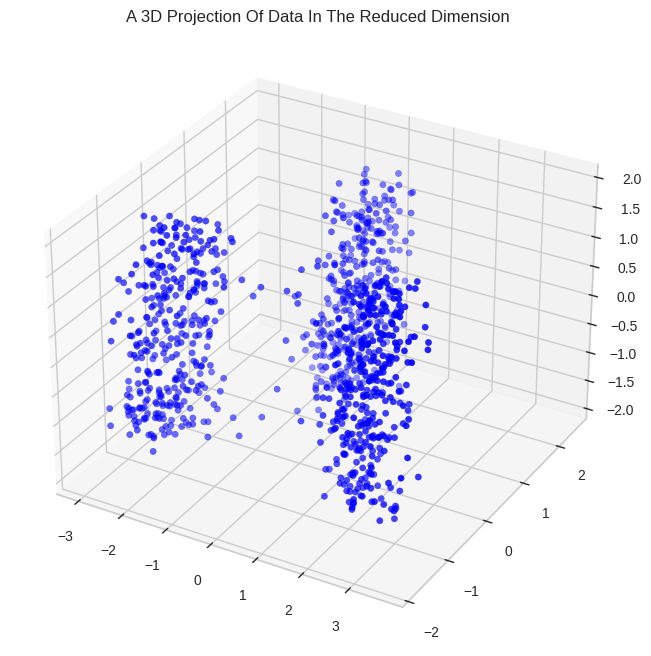

In [13]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

shows a discrimination of data into three clusters

# EDA

Reletive Plot Of Features


<Figure size 800x550 with 0 Axes>

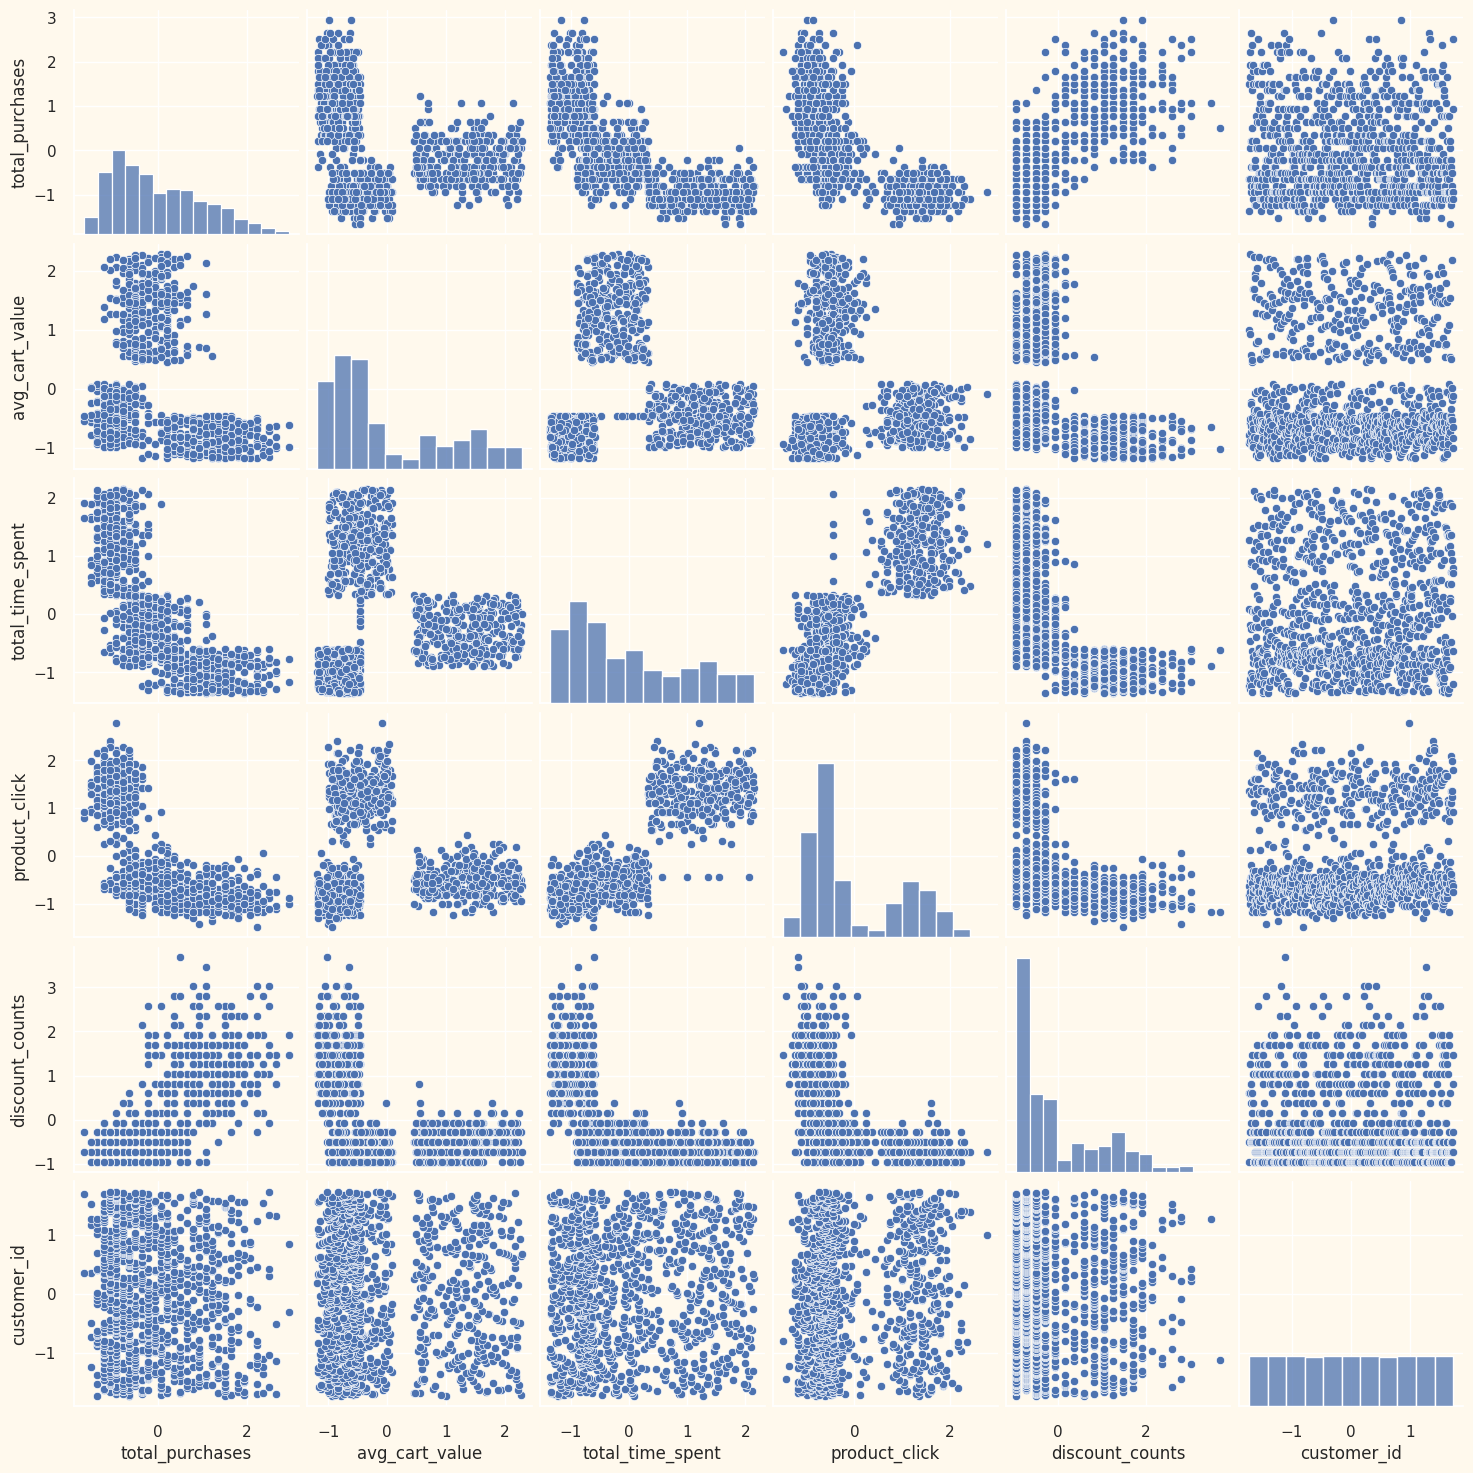

In [14]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
To_Plot = ["total_purchases","avg_cart_value", "total_time_spent", "product_click", "discount_counts", "customer_id"]
print("Reletive Plot Of Features")
plt.figure()
sns.pairplot(scaled_ds[To_Plot],palette= (["#682F2F","#F3AB60"]))
plt.show()

product click seems to have outliers\
discount counts seems to have outliers

average cart value, total purchases pair clearly shows a clustering the dataset to 3 categories\
average cart value, product click pair clearly shows a clustering the dataset to 3 categories\
average cart value, total time spent pair clearly shows a clustering the dataset to 3 categories

<Axes: >

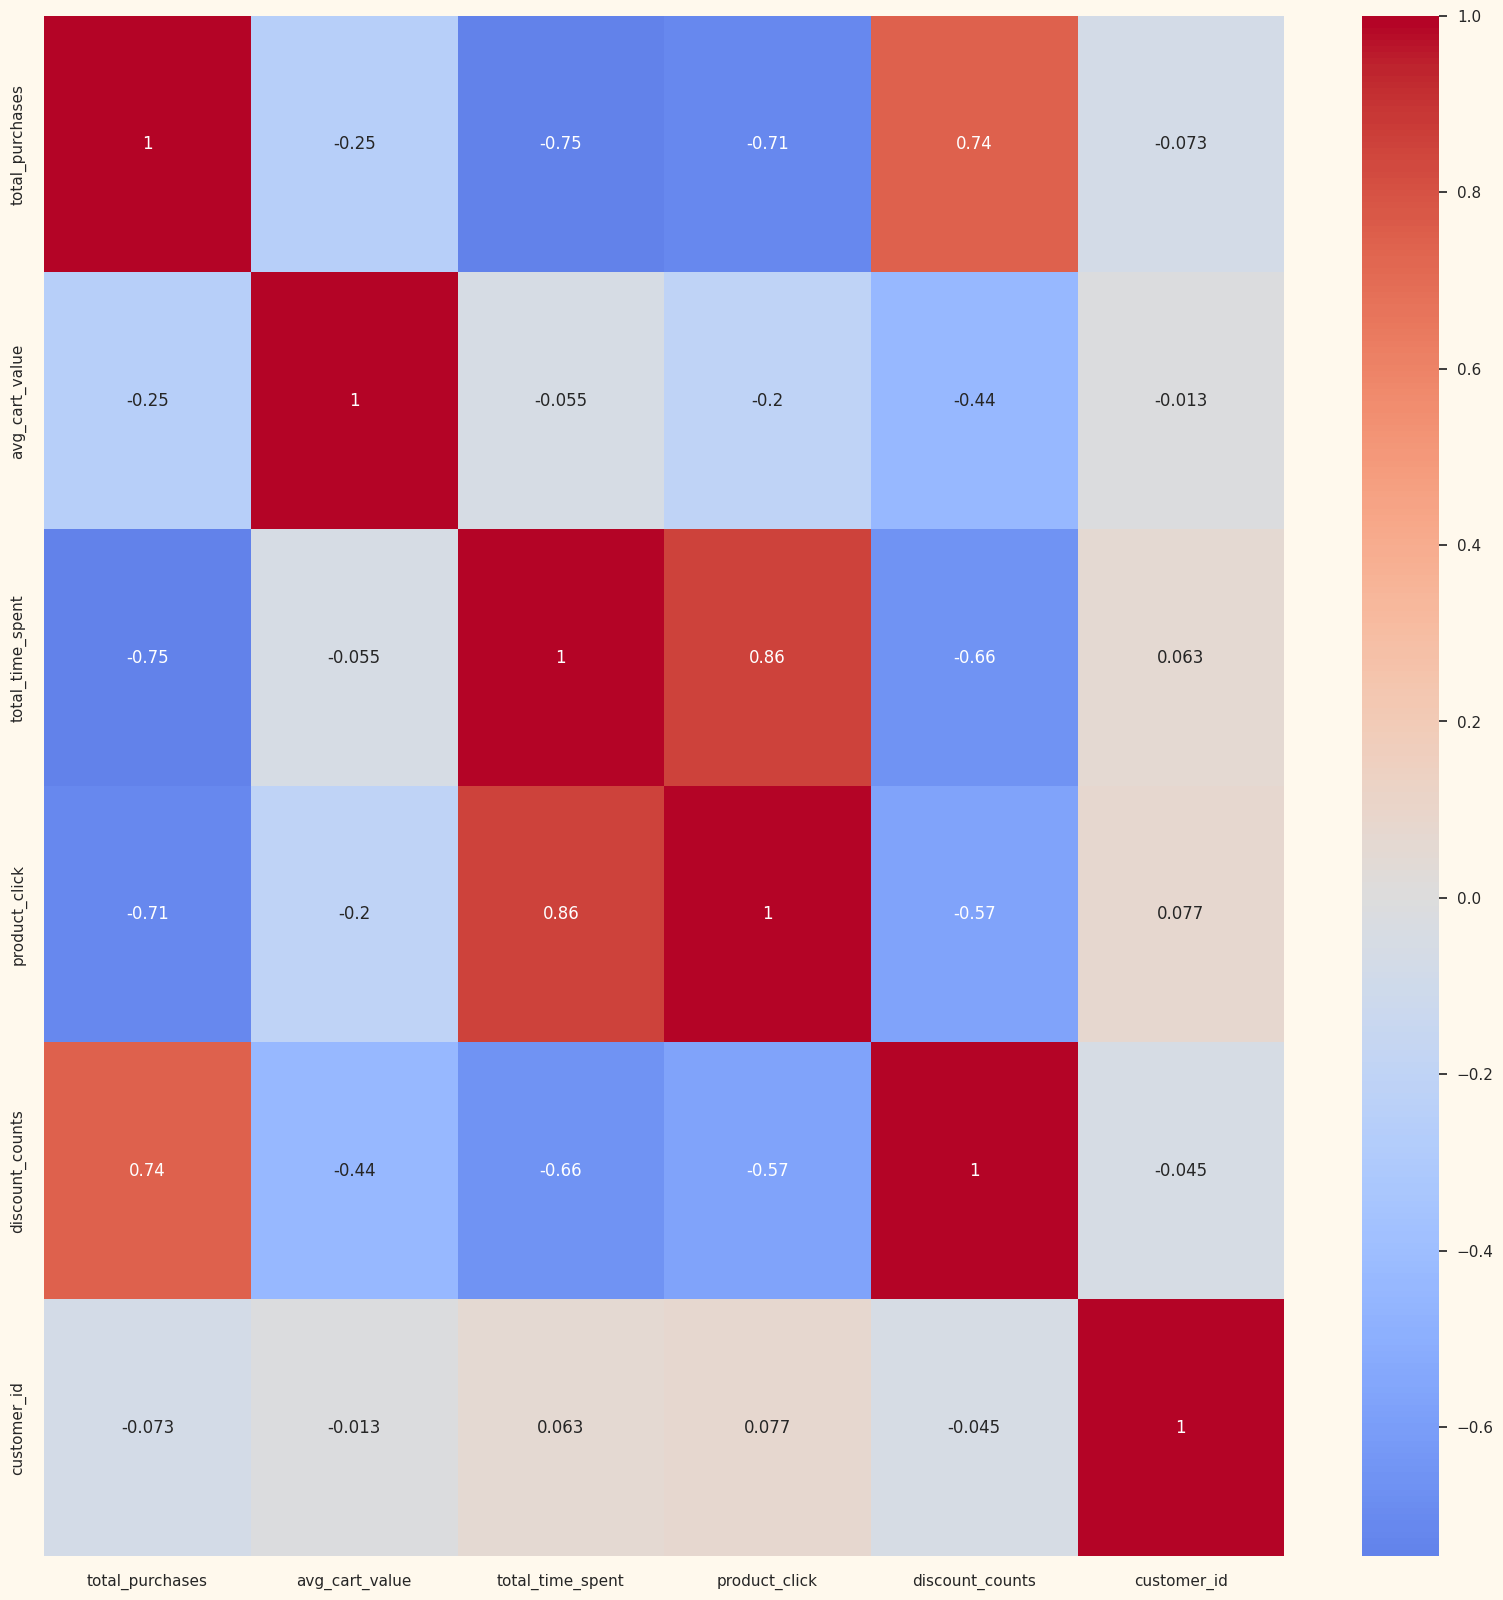

In [15]:
corrmat= scaled_ds.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap="coolwarm", center=0)

Note\
total purchases have strong positive linear relationship with discount counts\
total time spend have strong positive linear relationship with product click\
total time spend have strong negative linear relationship with total purchases


# Model Selection

## Clustering

Steps involved in the Clustering

- Elbow Method to ensure the number of clusters to be formed
- Clustering via different models
- Examining the clusters formed via scatter plot


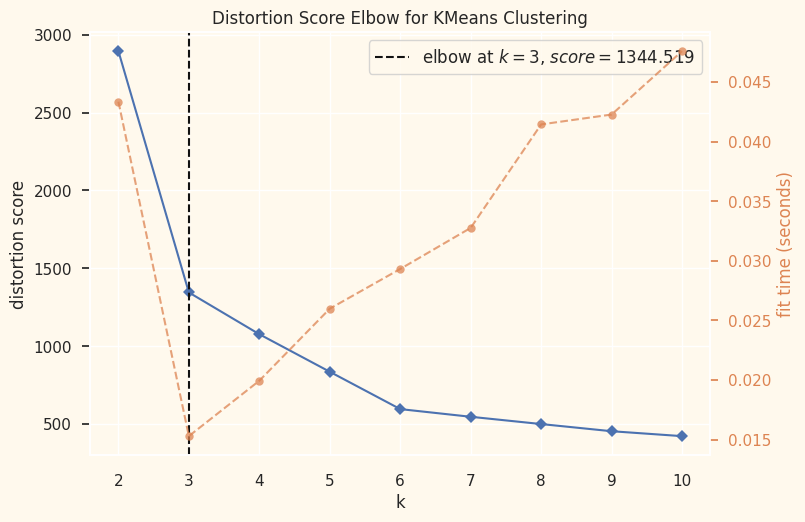

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Above cell ensures that there are 3 clusters

In [17]:
data = df.copy()

## Mean Shift Clustering

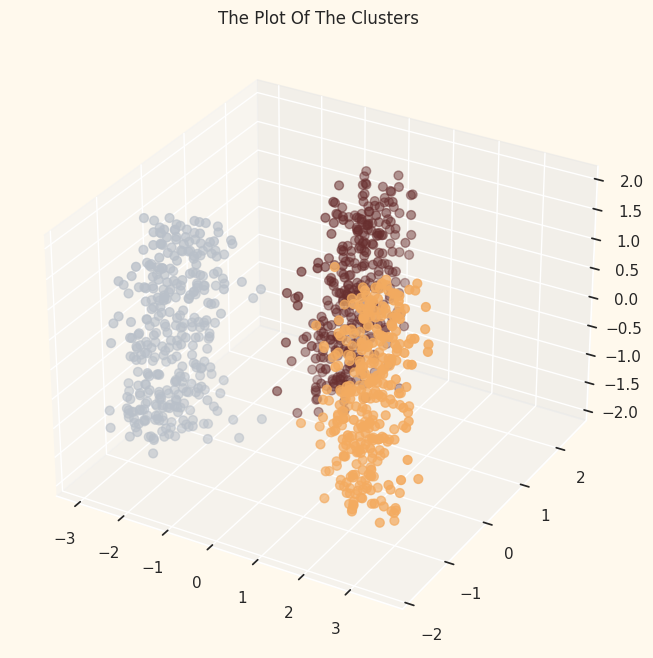

Silhouette Score: 0.5571817499547654


In [18]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift()
yhat_MeanShift = mean_shift.fit_predict(PCA_ds)

data['Clusters_MeanShift'] = yhat_MeanShift


fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=data['Clusters_MeanShift'], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()


from sklearn.metrics import silhouette_score

score = silhouette_score(PCA_ds, data['Clusters_MeanShift'])
print(f'Silhouette Score: {score}')

## Gaussian Mixture Model (GMM)

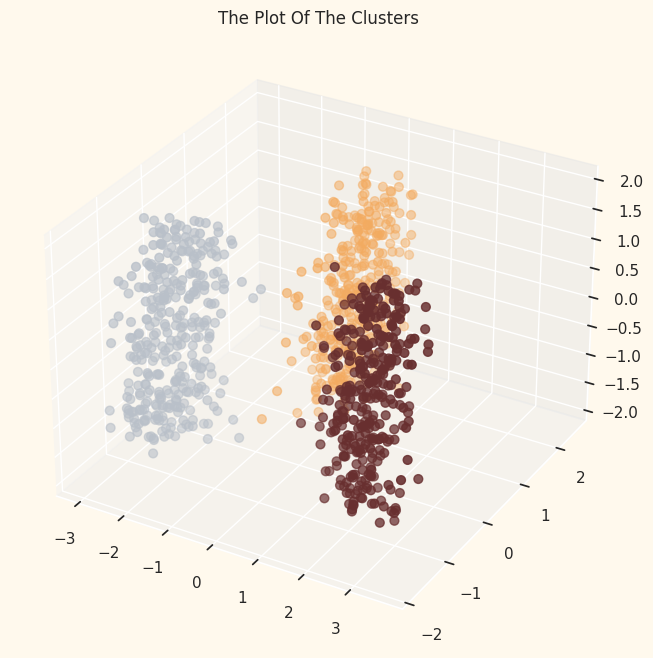

Silhouette Score: 0.5570748854536488


In [19]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
yhat_GMM = gmm.fit_predict(PCA_ds)

data['Clusters_GMM'] = yhat_GMM


fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=data['Clusters_GMM'], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()


from sklearn.metrics import silhouette_score

score = silhouette_score(PCA_ds, data['Clusters_GMM'])
print(f'Silhouette Score: {score}')

## K Means Clustering

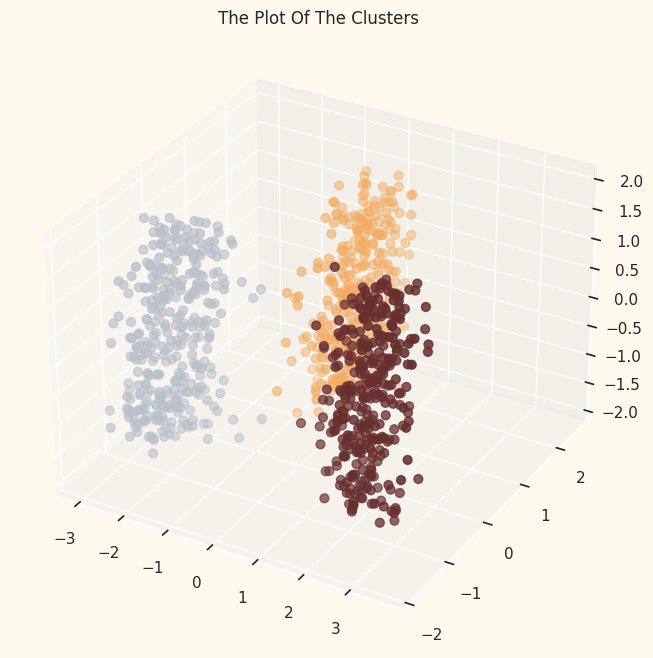

Silhouette Score: 0.597034032119383


In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
PCA_ds["Clusters"] = df['Clusters'] = kmeans.fit_predict(PCA_ds)

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

from sklearn.metrics import silhouette_score

score = silhouette_score(PCA_ds, df['Clusters'])
print(f'Silhouette Score: {score}')

## Agglomerative Clustering model

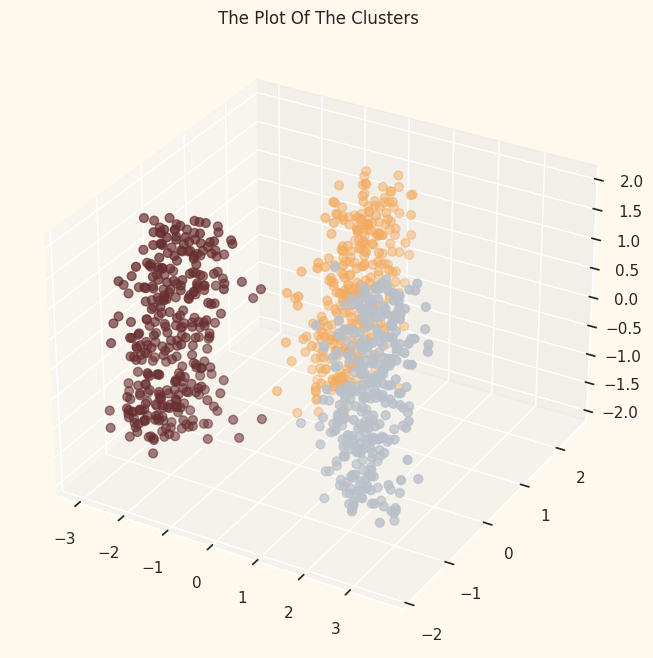

Silhouette Score: 0.5994942415582004


In [22]:
AC = AgglomerativeClustering(n_clusters=3)
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
df["Clusters"]= yhat_AC

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()


from sklearn.metrics import silhouette_score

score = silhouette_score(PCA_ds, df['Clusters'])
print(f'Silhouette Score: {score}')

Selected Model -  Agglomerative Clustering

Agglomerative Clustering was chosen for its ability to identify customer segments of varying shapes and densities, without assuming spherical clusters like K-Means. Its hierarchical nature, visualized through a dendrogram, provides valuable insights into the relationships between clusters and supports interpretable segmentation strategies. Given the potential for non-linear relationships in customer behavior, this flexibility makes Agglomerative Clustering a robust approach for identifying distinct customer groups within the e-commerce platform data.




# Model Evaluation

In [ ]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

The clusters seem to be fairly distributed.

In [ ]:
pl = sns.scatterplot(data = df,x=df["total_time_spent"], y=df["total_purchases"],hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On total_time_spent and total_purchases")
plt.legend()
plt.show()

total_time_spent vs  total_purchases shows the clusters pattern

cluster 0: high total_time_spent & low total_purchases\
cluster 1: low total_time_spent & high total_purchases\
cluster 2: average total_time_spent & average total_purchases


In [ ]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["total_purchases"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["total_purchases"], palette=pal)
pl.set_title("Total Purchases")
plt.show()

From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers followed by cluster 2.

In [ ]:
plt.figure()
pl=sns.boxenplot(y=df["discount_counts"],x=df["Clusters"], palette= pal)
pl.set_title("Discount Counts")
plt.show()

cluster 1 bargain hunters claims the highest discount counts.

In [ ]:
plt.figure()
pl=sns.boxenplot(y=df["product_click"],x=df["Clusters"], palette= pal)
pl.set_title("Number of Product Clicks")
plt.show()

cluster 0; window shoppers view a large number of products whilst others have moderate product clicks.

In [ ]:
plt.figure()
pl=sns.boxenplot(y=df["avg_cart_value"],x=df["Clusters"], palette= pal)
pl.set_title("Average Cart Values")
plt.show()

cluster 2 can be identified as high spenders have high average cart values as mentioned in the question confirming our clustering accuracy. Other two groups have moderate average cart values.

# Conclusion

## Identifying Clusters

Clusters follows the patterns given in the question\
cluster 0: Window Shoppers \
cluster 1: Bargain Hunters\
cluster 2: High Spenders